## Importa Librerias

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
import xgboost as xgb
from datetime import date, datetime
import time
import calendar
import matplotlib.pyplot as plt
import seaborn as sns
import time

## Carga de datos

In [ ]:
# Leer los archivos CSV
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
sub = pd.read_csv('sample_submission.csv')
oil = pd.read_csv('oil.csv')
holiday = pd.read_csv('holidays_events.csv')
store = pd.read_csv('stores.csv')
tran = pd.read_csv('transactions.csv')


## Preprocesado de datos

Esta función toma un DataFrame con una columna de fechas y realiza una serie de transformaciones para agregar información útil sobre las fechas, como el día de la semana, el año, el mes, el día del mes y si es un día de pago.

In [ ]:
def preprocess_train(df):
    df['date'] = df['date'].map(lambda x: date.fromisoformat(x))
    df['weekday'] = df['date'].map(lambda x: x.weekday())
    df['year'] = df['date'].map(lambda x: x.year)
    df['month'] = df['date'].map(lambda x: x.month)
    df['day'] = df['date'].map(lambda x: x.day)
    df['eomd'] = df['date'].map(lambda x: calendar.monthrange(x.year, x.month)[1])
    df['payday'] = ((df['day'] == df['eomd'])|(df['day'] == 15)).astype(int)
    df.drop(['id', 'eomd'], axis=1, inplace=True)
    return df

train = preprocess_train(train)
test = preprocess_train(test)

In [ ]:
train.head()

,date,store_nbr,family,sales,onpromotion,weekday,year,month,day,payday
0,2013-01-01,1,AUTOMOTIVE,0.0,0,1,2013,1,1,0
1,2013-01-01,1,BABY CARE,0.0,0,1,2013,1,1,0
2,2013-01-01,1,BEAUTY,0.0,0,1,2013,1,1,0
3,2013-01-01,1,BEVERAGES,0.0,0,1,2013,1,1,0
4,2013-01-01,1,BOOKS,0.0,0,1,2013,1,1,0


In [ ]:
test.head()

,date,store_nbr,family,onpromotion,weekday,year,month,day,payday
0,2017-08-16,1,AUTOMOTIVE,0,2,2017,8,16,0
1,2017-08-16,1,BABY CARE,0,2,2017,8,16,0
2,2017-08-16,1,BEAUTY,2,2,2017,8,16,0
3,2017-08-16,1,BEVERAGES,20,2,2017,8,16,0
4,2017-08-16,1,BOOKS,0,2,2017,8,16,0


En esta función se filtran y separan los eventos en el DataFrame original, identificando eventos regulares y eventos relacionados con terremotos, y devuelve estos conjuntos de datos separados.

In [ ]:
def preprocess_holiday(df):
    df['date'] = df['date'].map(lambda x: date.fromisoformat(x))
    df = df[(df['transferred']==False)&(df['type']!='Work Day')]
    event = df[df['type']=='Event']
    earthquake = event[event['description'].str.startswith('Terremoto Manabi')]
    event = event[event['description'].str.startswith('Terremoto Manabi')==False]
    return df, event, earthquake


- Primero se llama a la función preprocess_holiday con el DataFrame `'holiday'` y guarda los resultados en tres variables: `'holiday'` (DataFrame original modificado), `'event' `(que contiene eventos que no son terremotos) y `'earthquake'` (que contiene eventos relacionados con terremotos).

- Selecciona solo las columnas `'date'` y `'description'` del DataFrame `'event'`, lo que crea un nuevo DataFrame llamado `'event'` con solo esas dos columnas.

- Renombra la columna `'description'` en el DataFrame `'event'` como `'event_name'`.

- Selecciona solo las columnas `'date'` y `'description'` del DataFrame `'earthquake'` y crea un df con el mismo nombre

- Renombra la columna `'description'` en el DataFrame `'earthquake'` como `'earthquake'`.

- Luego, se crean varios DataFrames adicionales `'h_local'`, `'h_regional'`, y `'h_national'` a partir del DataFrame `'holiday'` filtrando por diferentes valores en la columna `'locale'`. Estos DataFrames se crean para diferentes tipos de días festivos: locales, regionales y nacionales.

  - `h_local` contiene días festivos locales con columnas 'date', `'city'` y `'local_holiday_name'`.
  - `h_regional` contiene días festivos regionales con columnas `'date'`, `'state'` y `'regional_holiday_name'`.
  - `h_national` contiene días festivos nacionales con columnas `'date'` y `'national_holiday_name'`.

In [ ]:
holiday, event, earthquake = preprocess_holiday(holiday)

event = event[['date', 'description']]
event.rename({'description': 'event_name'}, axis=1, inplace=True)

earthquake = earthquake[['date', 'description']]
earthquake.rename({'description': 'earthquake'}, axis=1, inplace=True)

h_local = holiday[holiday['locale']=='Local']
h_local = h_local[['date', 'locale_name', 'description']]
h_local = h_local.rename({'locale_name': 'city', 'description': 'local_holiday_name'}, axis=1)

h_regional = holiday[holiday['locale']=='Regional']
h_regional = h_regional[['date', 'locale_name', 'description']]
h_regional = h_regional.rename({'locale_name': 'state', 'description': 'regional_holiday_name'}, axis=1)

h_national = holiday[holiday['locale']=='National']
h_national = h_national[['date', 'description']]
h_national = h_national.rename({'description': 'national_holiday_name'}, axis=1)

## Merge de datasets

En resumen, la función merge_tables(df) toma un DataFrame df y realiza varias fusiones de datos con otros DataFrames (`store, event, earthquake, h_local, h_regional, h_national, tran`) utilizando diferentes columnas como claves de unión. Estas fusiones agregan información adicional a las filas de df relacionadas con tiendas, eventos, terremotos, días festivos locales, regionales, nacionales y transacciones.

 Además, la función rellena los valores faltantes en el DataFrame resultante con '0' o 0 según corresponda. El resultado final es un DataFrame enriquecido con información combinada de diversas fuentes de datos.



In [ ]:
def merge_tables(df):
    df = df.merge(store, on='store_nbr', how='left')
    df = df.merge(event, on='date', how='left').fillna('0')
    df = df.merge(earthquake, on='date', how='left').fillna('0')
    df = df.merge(h_local, on=['date', 'city'], how='left').fillna('0')
    df = df.merge(h_regional, on=['date', 'state'], how='left').fillna('0')
    df = df.merge(h_national, on='date', how='left').fillna('0')
    df = df.merge(tran, on=['date', 'store_nbr'], how='left').fillna(0)

    return df

train = merge_tables(train)
test = merge_tables(test)

## Label encoding

El siguiente código itera a través de las columnas especificadas como características categóricas en cat_features en los DataFrames train y test. Utiliza el LabelEncoder para convertir las etiquetas categóricas en valores numéricos, lo que permite que estos DataFrames se utilicen en algoritmos de aprendizaje automático que requieren características numéricas en lugar de categóricas.

LabelEncoder:

Propósito: LabelEncoder se utiliza para codificar etiquetas categóricas en valores numéricos enteros. Asigna un número único a cada etiqueta en función de su posición en una lista ordenada de etiquetas únicas.

In [ ]:
cat_features = ['family', 'store_nbr', 'city', 'state', 'type', 'cluster',
                'event_name', 'earthquake', 'local_holiday_name', 'regional_holiday_name', 'national_holiday_name']
for col in cat_features:
    le = LabelEncoder()
    train[col] = le.fit_transform(train[col])
    test[col] = le.transform(test[col])

In [ ]:
train.head()

,date,store_nbr,family,sales,onpromotion,weekday,year,month,day,payday,city,state,type,cluster,event_name,earthquake,local_holiday_name,regional_holiday_name,national_holiday_name,transactions
0,2013-01-01,0,0,0.0,0,1,2013,1,1,0,18,12,3,12,0,0,0,0,26,0.0
1,2013-01-01,0,1,0.0,0,1,2013,1,1,0,18,12,3,12,0,0,0,0,26,0.0
2,2013-01-01,0,2,0.0,0,1,2013,1,1,0,18,12,3,12,0,0,0,0,26,0.0
3,2013-01-01,0,3,0.0,0,1,2013,1,1,0,18,12,3,12,0,0,0,0,26,0.0
4,2013-01-01,0,4,0.0,0,1,2013,1,1,0,18,12,3,12,0,0,0,0,26,0.0


## Divide los datos en train y validation

La función preprocess_dataset(`df, train_date: list, valid_date: list`) toma un DataFrame df y dos listas de fechas `train_date y valid_date`. Luego, agrega dos columnas adicionales al DataFrame df llamadas `is_train` y `is_valid`.

Estas columnas se utilizan para marcar si una fecha en el DataFrame df pertenece al conjunto de entrenamiento, al conjunto de validación o a ninguno de los conjuntos.

In [ ]:
def preprocess_dataset(df, train_date: list, valid_date: list):
    df['is_train'] = df['date'].map(lambda x: x in train_date)
    df['is_valid'] = df['date'].map(lambda x: x in valid_date)
    return df


train_date = train['date'].unique()[-227:-31].tolist()
valid_date = train['date'].unique()[-31:].tolist()
train = preprocess_dataset(train, train_date, valid_date)

In [ ]:
print('train date from {} to {}'.format(min(train_date), max(train_date)))
print('valid date from {} to {}'.format(min(valid_date), max(valid_date)))

train date from 2017-01-01 to 2017-07-15
valid date from 2017-07-16 to 2017-08-15


## Set X and y
- Calcula el logaritmo natural (base e) de la columna `'sales'` en el DataFrame `'train'` y lo almacena en la variable `'y'`. Esto se hace para transformar los valores de `'sales'` y puede ser útil en el modelado, especialmente cuando los datos no siguen una distribución normal.

- Crea un DataFrame `'X_train'` eliminando las columnas `'date'`, `'sales'` y `'year'` del DataFrame `'train'`. `'X_train'` contendrá las características (variables independientes) utilizadas para entrenar el modelo

- Crea un DataFrame `'X_test'` eliminando las columnas `'date'` y `'year'` del DataFrame `'test'`. `'X_test'` contendrá las mismas características que `'X_train'` y se utiliza para hacer predicciones con un modelo entrenado.

In [ ]:
y = np.log(train['sales'] + 1)
X_train = train.drop(['date', 'sales', 'year'], axis=1)
X_test = test.drop(['date', 'year'], axis=1)

## Establece los parametros de XGBoost

- `'verbosity'`: 2: Este parámetro controla el nivel de verbosidad (cantidad de información impresa) durante el proceso de entrenamiento del modelo. Un valor de 2 significa que se mostrarán mensajes detallados durante el entrenamiento.

- `'objective'`: 'reg:squarederror': Define la función de pérdida u objetivo que se utilizará para el entrenamiento del modelo. En este caso, se utiliza 'reg:squarederror', que corresponde a la regresión de mínimos cuadrados (RMSE, Root Mean Squared Error).

- `'eval_metric'`: 'rmse': Especifica la métrica de evaluación que se utilizará para medir el rendimiento del modelo. en este caso, 'rmse' representa el Root Mean Squared Error (Error Cuadrático Medio de la Raíz).

- `'random_state'`: 42: Establece una semilla elegida de forma arbitraria para garantizar que el entrenamiento del modelo sea reproducible.

- `'learning_rate'`: 0.1: Controla la velocidad de aprendizaje del modelo. Un valor de 0.1 significa que los pasos serán moderados.

- `'subsample'`: 0.8: Este parámetro determina la fracción de las muestras (observaciones) que se utilizarán para entrenar cada árbol en el modelo. Un valor de 0.8 significa que se seleccionará aleatoriamente el 80% de las muestras para entrenar cada árbol.

- `'colsample_bytree'`: 0.8: Controla la fracción de características (columnas) que se utilizarán para entrenar cada árbol en el modelo. Un valor de 0.8 significa que se seleccionará aleatoriamente el 80% de las columnas para cada árbol.

- `'reg_alpha'`: 0.01: Este parámetro aplica regularización L1 (Lasso) a las ponderaciones de las características del modelo para evitar el sobreajuste. Un valor bajo de 0.01 siendo esta, una regularización débil.

- `'reg_lambda'`: 1: Aplica regularización L2 (Ridge) con un valor de 1 indicando una regularización moderada.

- `'max_depth'`: 10: Establece la profundidad máxima de los árboles en el modelo para prevenir overfitti.

- `'n_estimators'`: 200: Especifica el número de árboles que se utilizarán en el modelo XGBoost. En este caso, se utilizan 200 árboles.

- `'min_child_weight'`: 47: Controla la cantidad mínima de muestras que se requieren en un nodo hoja del árbol.

In [ ]:
xgb_params = {
    'verbosity': 2,
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'random_state': 42,
    'learning_rate': 0.1,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'reg_alpha': 0.01,
    'reg_lambda': 1,
    'max_depth': 10,
    'n_estimators': 200,
    'min_child_weight': 47
}

## Corre el model XGB

- Define una función llamada rmsle que calcula el error RMSLE (`Root Mean Squared Logarithmic Error`) entre las predicciones y los valores verdaderos.

- Extrae índices para los conjuntos de entrenamiento y validación basados en la columna `'is_train'` y `'is_valid'` en el DataFrame `X_train`.

- Crea conjuntos de datos de entrenamiento y validación, así como etiquetas correspondientes, eliminando las columnas `'is_train'` y `'is_valid'`.

- Convierte los conjuntos de datos en objetos `DMatrix` para ser utilizados por el algoritmo XGBoost.

- Configura hiperparámetros para el entrenamiento de XGBoost, como el número máximo de rondas de impulso y el número mínimo de rondas para detener el entrenamiento temprano.

- Inicia el entrenameinto del modelo usando los parametros anteriores

- Realiza **predicciones en el conjunto de validación y en el conjunto de prueba**.

- Calcula el tiempo transcurrido para el entrenamiento del modelo.

- Calcula el RMSE (`Root Mean Squared Error`) y el RMSLE (`Root Mean Squared Logarithmic Error`) para evaluar el rendimiento del modelo en el conjunto de validación.

- Imprime las métricas de rendimiento y el tiempo de ejecución.

- Retorna varias variables resultantes, incluyendo las predicciones en el conjunto de validación (`xgb_oof`), el modelo entrenado (`model`), los resultados de la evaluación (evals_result), las predicciones en el conjunto de prueba (`xgb_pred`), los valores verdaderos en el conjunto de validación (`y_val`) y el conjunto de validación sin las columnas `'is_train'` y `'is_valid'` (`X_val`).

In [ ]:
# Función para calcular RMSLE (Root Mean Squared Logarithmic Error)
def rmsle(y_true, y_pred):
    return np.sqrt(np.mean(np.square(np.log1p(y_pred) - np.log1p(y_true))))

# Función de entrenamiento
def xgboost(X_train, y, xgb_params, X_test):
    # Inicia un temporizador para medir el tiempo de ejecución
    start = time.time()

    # Extrae índices para los conjuntos de entrenamiento y validación
    trn_idx = X_train[X_train['is_train'] == True].index.tolist()
    val_idx = X_train[X_train['is_valid'] == True].index.tolist()

    # Crea conjuntos de datos de entrenamiento y validación, así como etiquetas correspondientes
    X_tr = X_train.loc[trn_idx, :].drop(['is_train', 'is_valid'], axis=1)
    X_val = X_train.loc[val_idx, :].drop(['is_train', 'is_valid'], axis=1)
    y_tr = y[trn_idx]
    y_val = y[val_idx]

    # Convierte los conjuntos de datos en objetos DMatrix para XGBoost
    xgb_train = xgb.DMatrix(X_tr, label=y_tr)
    xgb_valid = xgb.DMatrix(X_val, label=y_val)
    evallist = [(xgb_train, 'train'), (xgb_valid, 'eval')]
    evals_result = dict()

    # Configura hiperparámetros para el entrenamiento de XGBoost
    num_boost_round  = 4000
    early_stopping_rounds = 10

    # Entrena un modelo XGBoost
    model = xgb.train(params=xgb_params, dtrain=xgb_train, evals=evallist, evals_result=evals_result,
                      verbose_eval=300, num_boost_round=num_boost_round , early_stopping_rounds=early_stopping_rounds)

    # Realiza predicciones en el conjunto de validación
    xgb_oof = np.zeros(y_val.shape[0])
    xgb_oof = model.predict(xgb_valid, iteration_range=(0, model.best_iteration))

    # Prepara los datos de prueba para hacer predicciones
    xgb_test = xgb.DMatrix(X_test)
    xgb_pred = pd.Series(model.predict(xgb_test, iteration_range=(0, model.best_iteration)),
                         name='xgb_pred')

    # Calcula el tiempo transcurrido para el entrenamiento
    elapsed = time.time() - start

    # Calcula el RMSE (Root Mean Squared Error) y RMSLE
    error_value = mean_squared_error(y_val, xgb_oof, squared=False)
    rmsle_value = rmsle(y_val, xgb_oof)

    # Imprime las métricas y el tiempo de ejecución
    print(f"xgb RMSE: {error_value:.6f}, RMSLE: {rmsle_value:.6f}, Elapsed time: {elapsed:.2f} sec\n")

    # Retorna varias variables resultantes, incluyendo las predicciones y el modelo
    return xgb_oof, model, evals_result, xgb_pred, y_val, X_val

In [ ]:
%%time
oof, model, evals_result, pred, y_val, X_val = xgboost(X_train, y, xgb_params, X_test)
#xgb_oof, model, evals_result, xgb_pred, y_val, X_val = basic_xgboost(X_train, y, xgb_params, X_test)

[05:02:21] WARNING: ../src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[05:02:22] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 890 extra nodes, 0 pruned nodes, max_depth=10
[0]	train-rmse:3.60776	eval-rmse:3.62903
[05:02:23] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 958 extra nodes, 0 pruned nodes, max_depth=10
[05:02:23] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 880 extra nodes, 0 pruned nodes, max_depth=10
[05:02:24] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 918 extra nodes, 0 pruned nodes, max_depth=10
[05:02:24] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 928 extra nodes, 0 pruned nodes, max_depth=10
[05:02:25] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 924 extra nodes, 0 pruned nodes, max_depth=10
[05:02:26] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 918 extra nodes, 0 pruned nodes, max_depth=10
[05:02:26] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 101

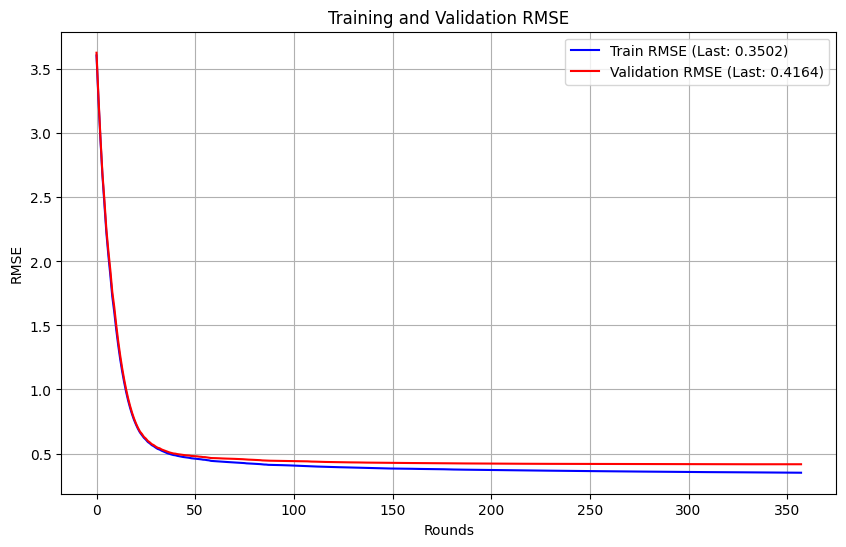

In [ ]:
def plot_loss(evals_result):
    train_error = evals_result['train']['rmse']
    eval_error = evals_result['eval']['rmse']

    last_train_rmse = train_error[-1]
    last_eval_rmse = eval_error[-1]

    plt.figure(figsize=(10, 6))
    plt.plot(train_error, label=f'Train RMSE (Last: {last_train_rmse:.4f})', color='blue')
    plt.plot(eval_error, label=f'Validation RMSE (Last: {last_eval_rmse:.4f})', color='red')
    plt.xlabel('Rounds')
    plt.ylabel('RMSE')
    plt.title('Training and Validation RMSE')
    plt.legend()
    plt.grid()
    plt.show()

# Llama a la función para crear la gráfica
plot_loss(evals_result)

En la gráfica se puede apreciar

## Crea el documento que evalua la plataforma

- Crea una nueva columna llamada '`sales'` en un DataFrame llamado `'sub'`.
Transforma las predicciones en esta columna de manera que cualquier valor negativo se convierte en 0 y luego invierte la transformación logarítmica aplicada anteriormente a la variable objetivo `'sales'`.
- Guarda el DataFrame `'sub'` en un archivo CSV llamado `'submission.csv'` el cual es el que se sube a la plataforma.



In [ ]:
sub['sales'] = np.exp(pred.map(lambda x: max(x, 0))) - 1
sub.to_csv('submission.csv', index=False)